ABSTRACT: The occupancy of heated apartments, serviced by the District Heating Systems (DHS) is one of the important features of their control in terms of daily operation, as well as medium- to long-term planning, yet one of the most difficult signals to continuously and accurately acquire with a reasonable cost and no intrusive effect to privacy. The researchers today address this problem with unsupervised approaches, introducing inaccuracies due to commonly used sensors (lack of) responsiveness and corresponding rolling features delays. Supervised approaches are implemented with much better performance, but they require acquisition of ground truth data, which is either expensive or privacy intrusive. The main goal behind the work presented in this paper was to design and implement a robust, responsive, ventilation-aware, weakly-supervised, inherently interpretable occupancy classifier on three-fold data stream, namely CO2, relative humidity and room temperature signals. Our proposal builds on the idea of hybrid method, where unsupervised approach is used for collection of ground truth data, with the confidence measures (weak labeling), which is then filtered for strong confidence thresholds and used for training the supervised Machine Learning classifier, with additional complex features. In this paper, we report our findings on the weak labeling of occupancy, by using unsupervised method which delivers occupancy scores, while relying on the above three main signals. The method considers weigthed features of 9-minute slopes of CO2 and humidity ratio, with additional indicative signal of excess CO2 concentration over the CO2 baseline, normalized by using logistic function, to calculate occupancy scores, which will then be used in weak supervision approach. For illustration, the approach is demonstrated also as independent occupancy detection method, with added consideration of hysteresis and highlighting window opening events.

# Introduction

For District Heating System (DHS), maintaining optimal energy consumption while ensuring that heated spaces achieve the optimal thermal comfort is a holy grail. However, number of measurements needed to achieve and maintain that aim is overly extensive and the cost of related data acqusition infrastructure but also other concerns (for example, privacy issues) significantly exceeds the cost of thermal losses, induced by commonly implemented automatic or semi-automatic control on supply side. To only briefly demonstrate the vast diversity of data required for precise estimation of heat demand, we refer to irregular occupancy patterns, varying window opening schedule, overall floor layout (Li et al, 2022), density of indoor vegetation (Jiang et al, 2024), etc. Lack of all those features can hinder the ability to sustain the optimal temperature in the DHS heated spaces. Many of these factors have already been considered in scientific work.

This research originated within a larger project which deals with intelligent control of DHS system (Zdravković et al, 2024). During the course of the project, the found discrepancies observed between predicted indoor temperatures and actual sensor measurements were attributed to the fact that the number of occupants inside the heated spaces has an moderately high effect on the thermal comfort goals, with literature reporting that more than 50% of the energy consumption could be saved if accurate occupancy numbers were readily available (Ahmad et al, 2021). This indication led to the new research question, related to how the occupancy in the heated space be accurately detected, in a real time, based only on the data readily available by smart home devices (commonly measuring the indoor temperature, CO₂ and relative humidity), and how can this information be directly integrated for DHS optimization.

Occupancy detection has been addressed to a large extent in previous research. Various types of sensors were implemented for this purpose (Chen et al, 2018), including: passive infrared (PIR) sensors which detect changes in infrared radiation; smart meter sensors, which capture patterns of occupant–appliance interaction; environmental sensors, measuring parameters such as CO₂ concentration, temperature, humidity, light, and pressure; camera-based systems; and sensors that infer occupancy based on Wi-Fi connection data. Most of these systems are costly to implement with additional significant negative effect of disrupting the privacy of occupants, which is why those solutions were not found as viable.

In considering both unsupervised and supervised (ground truth data on occupancy is available) occupancy detection approaches, different features have been found useful in the literature review. Some papers rely only on CO2 concentration (Esmaieeli-Sikaroudi et al, 2024), while others also incorporate other parameters (Mogammadabadi et al, 2022; Pereira et al, 2018, Atashgahi et al, 2022), such as temperature, humidity, water consumption or energy consumption. The literature review uncovered that instantaneous detection is not achievable only with CO2 sensors, as it takes time for the CO2 concentration spiking to happen. Most of the studies report delays ranging from 8 minutes (Styliani et al, 2021) to 15 minutes (Jiang et al, 2020; Jin et al, 2015). A third group of works adopts a multimodal approach by incorporating visual data also. Mogammadabadi et al (2022) used CO2 concentration, relative humidity, and ambiental temperature for CNN-XGBoost prediction algorithm, which was tested across three different rooms, achieving the accuracies of 98%, 75%, and 87%. In contrast, Esmaieeli-Sikaroundi, et al (2024) utilized only CO2 concentration for physics-based Hidden Markov Model and reported 94.7% accuracy with real-life data. Similar findings were reported across other studies, suggesting that the quality of the data and the effectiveness of models training are more critical to predict accuracy than the number of input variables used for algorithm training. The exception was when camera-based systems were employed, as those systems can accurately count the occupants. However, their implementation is significantly more costly, and is most often used for labeling data, for later training of the classification and regression models.

When considering whether an occupancy detection model can operate on a data stream as an online system, the literature review reveals mixed findings. Most existing studies are based on experimental setups in which occupancy changes follow a strict schedule (Esmaieeli-Sikaroudi et al, 2024; Mohammadabadi et al, 2022; Jin et al, 2015). These systems were not designed for online application, as many authors state that employing such systems in real-world conditions would be left for future work. Furthermore, these studies often rely on supervised learning approaches with clearly labeled data (Jiang et al, 2020; Karasoulas et al, 2023; Pereira et al, 2018). For a real-world case of lacking ground truth data, this is not an option, as the data is collected directly from the apartments heated by DHS. In this context, labeling is not feasible, as installing cameras in private homes, or asking occupants to manually record changes would both be impractical and yield unreliable data.
To the best of our knowledge, a real-time, online, and unsupervised occupancy detection method for the real-world case of DHS-heated apartment buildings has not yet been reported. One study that deals with a related problem is presented by Atashgahi et al (2022), who proposed the Adaptive LSTM-Autoencoder Change-Point Detection (ALACPD) method for unsupervised, online change-point detection in multivariate time series. Their approach integrates LSTM-based autoencoders with an autoregressive component and employs an ensemble of models to identify changes in data distribution by monitoring reconstruction loss. While their method achieves state-of-the-art performance across several benchmark datasets, it focuses on general change-point detection tasks with annotated ground-truth labels. In contrast, the present study addresses the specific challenge of real-time occupancy detection in DHS-heated apartments, where no labeled data is available and the ultimate goal is to integrate unsupervised detection directly into the optimization of DHS operation.

To address the identified challenges of unsupervised model inaccuracies due to commonly used sensors (lack of) responsiveness and corresponding rolling features delays, and those of supervised approaches, which despite much better performance, are not often viable as they require acquisition of ground truth data, which is either expensive or privacy-intrusive, we propose a weak-supervision method. In this method, unsupervised approach is used for collection of ground truth data, with the confidence measures (weak labeling), which is then filtered for strong confidence thresholds and used for training the supervised Machine Learning classifier, with additional complex features. In this paper, we report our findings on the weak labeling of occupancy, by using unsupervised method which delivers occupancy scores, while relying on the above three main signals. The method considers weigthed features of 9-minute slopes of CO2 and humidity ratio (agnostic to room temperature), with additional indicative signal of excess CO2 concentration, over the CO2 baseline (rolling low quantile over 24 hours), normalized by using logistic function, to calculate occupancy scores, which will then be used in weak supervision approach. For illustration, the approach is demonstrated also as independent occupancy detection method, with added consideration of hysteresis and highlighting window opening events.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore



import requests
import zipfile
import io
import warnings

import os
import shutil

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


season_start='2024-11-17 06:00:00'
season_end='2025-04-01 00:00:00'

In [2]:
# Download the zip file from GitHub
url_scada = "https://github.com/xai4heat/xai4heat/raw/main/datasets/scada_data_2024-25.zip"
url_thermionyx = "https://github.com/xai4heat/xai4heat/raw/main/datasets/thermionyx_data_2024-25_1min.zip"

response_scada = requests.get(url_scada)
response_thermionyx = requests.get(url_thermionyx)

with zipfile.ZipFile(io.BytesIO(response_scada.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dfs = pd.read_csv(f)

with zipfile.ZipFile(io.BytesIO(response_thermionyx.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dft = pd.read_csv(f)


# Processing Thermionyx data

dft['datetime'] = pd.to_datetime(dft['datetime'])
dft.set_index('datetime', inplace=True)
dft.sort_index(inplace=True)

dft['sensor_co2'] = dft['name'].str.endswith('_CO2')
name_parts = dft['name'].str.replace('_CO2$', '', regex=True).str.split('_', expand=True)
dft['block_name'] = name_parts[0]
dft['building_number'] = name_parts[1]
dft['apartment_number'] = name_parts[2]

dft.drop(columns=['probe_id', 'name'], inplace=True)



# Filter dft for block_name 'L4' and apartment_number '12'
dft_4 = dft[(dft['block_name'] == 'L4') & (dft['apartment_number'] == '12') & (dft['sensor_co2'] == True)].copy()[['temperature', 'relative_humidity', 'co2']]
dft_4 = dft_4.resample('3min').first().dropna(how='all')
#dft_4.head(20)




dfs_4=dfs[(dfs['location'] == 'TPS Lamela L4')].copy()[['datetime', 'e', 't_amb']]

dfs_4['datetime'] = pd.to_datetime(dfs_4['datetime'])
dfs_4['e'] = dfs_4['e'].replace(0, np.nan)
dfs_4['e']=dfs_4['e'].interpolate(method='linear')
dfs_4.set_index('datetime', inplace=True)
dfs_4 = dfs_4[~dfs_4.index.duplicated(keep='first')]
dfs_4 = dfs_4.resample('3min').first().dropna(how='all')
dfs_4.sort_index(inplace=True)

dfs_4['deltae']=(dfs_4['e']-dfs_4['e'].shift(1))*1000
dfs_4['deltae'] = dfs_4['deltae'].apply(lambda x: 0 if x <= 31 else x)

#Replacing outliers with linearly interpolated values
zs = zscore(dfs_4['deltae'])
dfs_4.loc[np.abs(zs) > 4, 'deltae'] = np.nan
dfs_4['deltae'] = dfs_4['deltae'].interpolate(method='linear')

date_range_season = (dfs_4.index >= pd.to_datetime(season_start)) & (dfs_4.index < pd.to_datetime(season_end))
dfs_4 = dfs_4[date_range_season].copy()
dfs_4.drop(columns=['e'], inplace=True)

#dfs_4.head(20)

dftc = pd.merge(dfs_4, dft_4, left_index=True, right_index=True, how='left')
dftc.rename(columns={'temperature': 'rtemp_4',
                     'relative_humidity': 'rhumid_4',
                     'co2': 'rco2_4',
                     }, inplace=True)



# Interpolate NaNs for room temperatures and key temperature signals
interp_cols = dftc.columns
for col in interp_cols:
    if col in dftc.columns:
        dftc[col] = pd.to_numeric(dftc[col], errors="coerce")  # force numeric
        dftc[col] = dftc[col].interpolate(method='time')       # time-based interpolation

# Optionally fill any remaining NaNs at the edges with nearest valid
dftc[interp_cols] = dftc[interp_cols].fillna(method='bfill').fillna(method='ffill')

dftc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64477 entries, 2024-11-17 06:00:00 to 2025-03-31 23:57:00
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t_amb     64477 non-null  float64
 1   deltae    64477 non-null  float64
 2   rtemp_4   64477 non-null  float64
 3   rhumid_4  64477 non-null  float64
 4   rco2_4    64477 non-null  float64
dtypes: float64(5)
memory usage: 3.0 MB


C:\Users\Milan\AppData\Local\Temp\ipykernel_95216\3533599625.py:83: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dftc[interp_cols] = dftc[interp_cols].fillna(method='bfill').fillna(method='ffill')


# Methodology and experimental results

For occupancy detection in heated apartments, indoor CO₂ is the most discriminative primary signal. CO₂ is a direct metabolic by-product of human presence. In a closed space, CO₂ generation rate from occupants balances with removal by ventilation and infiltration. Consequently, elevated absolute levels, sustained evening/nighttime plateaus, and positive short-term gradients (dCO₂/dt) after periods of low activity are strong indicators of occupancy events.

RH can confirm these inferences because human respiration and typical activities (talking, cooking, showering, drying clothes) introduce latent moisture. Although hygroscopic buffering by furnishings and building materials slows down RH level movements, features such as RH rate-of-change, humidity ratio change (Δw), and RH variance over short windows often align with occupancy transitions, especially when mechanical ventilation is weak or intermittent.

CO₂ need to be interpreted conditional on the ventilation state. When the building envelope is open (e.g., window ventilation), a rapid, concurrent decline in indoor CO₂, room temperature, and absolute humidity (convert RH to humidity ratio to remove temperature dependence) indicates high air-exchange. Under this regime, the decrease of CO₂ reflects dilution rather than absence of occupants and is therefore not an occupancy indicator. In contrast, during closed-envelope periods, sustained CO₂ plateaus, evening build-ups, and positive short-term gradients (dCO₂/dt) more reliably reflect human presence and metabolic generation.

In the remainder of this section, the methodology is presented in detail in separate contexts of feature engineering and weak classifier with illustration of the results of the proposed method on historical data.

## Feature engineering

Feature engineering design addresses two coupled inference tasks: (i) window-ventilation (open-envelope) detection and (ii) occupancy inference conditioned on a closed envelope. The pipeline is physics-informed and robust to short-interval sensor noise.

Without local thermostatic control, delivered energy is not a fast feedback signal but reflects the passive heat transfer driven by supply conditions and room–radiator temperature differences. Accordingly, it will not be considered in the model.

The feature engineering includes a pre-processing of the most influental features, namely CO2 and RH, room temperature to flatten sudden spikes (short-interval environmental streams often contain isolated spikes that inflate derivatives and trigger false change points), without actually changing physical steps. A Hampel filter (Hampel, 1974) is applied to eliminate point anomalies while preserving diagnostically valuable properties. Hampel filter is a sliding-window outlier remover. For each sample xi, it takes a centered window around it (equal number of points before and after), compute the window median and MAD (median absolute deviation). It flags xi as outlier if |xi - m|>k(1.4826*MAD), where k is typically 3. Finally, it replaces flagged points with the median.

Relative humidity (RH) is temperature dependent and therefore ambiguous in heated spaces. Transforming RH and indoor air temperature to humidity ratio w (kg/kg dry air) produces moisture metrics that reflect water-vapour content directly. During winter airing with colder, drier outdoor air, w will decline reliably even when RH may rise due to cooling. This feature therefore strengthen ventilation detection and help disambiguate CO₂ reductions driven by dilution from those driven by occupancy changes. Humidity ratio is calculated as:

$$ w = 0.62198 \cdot \frac{e}{P - e} $$

where P is atmospheric pressure in Pa, and e is an actual vapor pressure: e = RH*e<sub>s, Pa</sub>, where RH is relative humidity as a fraction 0 ≤ RH ≤ 1 and e<sub>s</sub> is saturation vapor pressure (Magnus formula):

$$ e_s = 6.112 \cdot \exp\left(\frac{17.62 \cdot T}{243.12 + T}\right) $$

To capture both rapid and sustained dynamics across rooms of different volumes and leakage rates, the pipeline computes finite-difference slopes over 9, 15 and 30 minutes for CO₂, temperature, and moisture. One of those lags will be adopted later as a lag for main signals in experiments. This lag is an important parameter of the model and its adoption depend on the conditions of the exploitation. The 9-minute horizon is sensitive to brief tilt-ventilation and group entries, while 15 minutes balances sensitivity and noise. Working with 30 minutes horizon will emphasize sustained regimes (for example, prolonged airing or settling plateaus).

$$ slope_k = \frac{x_t - x_{t-k}}{k \cdot 3/60} $$

Light exponential averaging of the slopes with adopted lag is done to reduce high-frequency noise without erasing physically meaningful edges.

Finally, robust z-scores (median/MAD) of the slopes are introduced with aim to produce indicators that are resilient to outliers and portable across rooms and seasons.

$$ z_x = 0.6745 \cdot \frac{x - \mathrm{median}(x)}{\mathrm{MAD}(x)} $$

Ventilation candidates are detected based on a conservative heuristic. A composite flag marks candidate window-ventilation intervals when the slopes of CO₂, temperature, and humidity ratio are simultaneously and substantially negative. This triad is the core physical signature of opening the envelope. The thresholds are set conservatively to favour precision.

Window ventilation candidate if:

$$ z_{\Delta CO_2} \leq -3.0 \quad \wedge \quad z_{\Delta T} \leq -2.0 \quad \wedge \quad z_{\Delta w} \leq -2.0 $$

Mechanical ventilation candidate if:

$$ z_{\Delta CO_2} \leq -3.0 \quad \wedge \quad z_{\Delta w} \leq -2.0 \quad \wedge \quad |z_{\Delta T}| < 2.0 $$

In [228]:
STEP_H = 3
PRESSURE_PA = 101_325.0          # standard pressure
USE_HAMPEL = True
HAMPEL_WINDOW = 5                # ~15 min centered window
HAMPEL_SIGMA = 3.0

df = dftc.sort_index().copy()


# ----------------------------
# Light spike removal (Hampel) — preserves step edges
# ----------------------------
if USE_HAMPEL:
    # Preserve raw
    df["rco2_4_raw"]   = df["rco2_4"]
    df["rtemp_4_raw"]  = df["rtemp_4"]
    df["rhumid_4_raw"] = df["rhumid_4"]

    # CO2
    med_co2 = df["rco2_4"].rolling(window=HAMPEL_WINDOW, center=True, min_periods=1).median()
    mad_co2 = (df["rco2_4"] - med_co2).abs().rolling(window=HAMPEL_WINDOW, center=True, min_periods=1).median()
    sigma_co2 = 1.4826 * mad_co2
    df["rco2_4"] = df["rco2_4"].where((df["rco2_4"] - med_co2).abs() <= HAMPEL_SIGMA * sigma_co2, med_co2)

    # Temperature
    med_T = df["rtemp_4"].rolling(window=HAMPEL_WINDOW, center=True, min_periods=1).median()
    mad_T = (df["rtemp_4"] - med_T).abs().rolling(window=HAMPEL_WINDOW, center=True, min_periods=1).median()
    sigma_T = 1.4826 * mad_T
    df["rtemp_4"] = df["rtemp_4"].where((df["rtemp_4"] - med_T).abs() <= HAMPEL_SIGMA * sigma_T, med_T)

    # RH
    med_RH = df["rhumid_4"].rolling(window=HAMPEL_WINDOW, center=True, min_periods=1).median()
    mad_RH = (df["rhumid_4"] - med_RH).abs().rolling(window=HAMPEL_WINDOW, center=True, min_periods=1).median()
    sigma_RH = 1.4826 * mad_RH
    df["rhumid_4"] = df["rhumid_4"].where((df["rhumid_4"] - med_RH).abs() <= HAMPEL_SIGMA * sigma_RH, med_RH)



# ----------------------------
# Humidity ratio & absolute humidity
# ----------------------------
# Saturation vapor pressure (Magnus, over water), in Pa
es_hPa = 6.112 * np.exp((17.62 * df["rtemp_4"]) / (243.12 + df["rtemp_4"]))   # hPa
es_Pa = es_hPa * 100.0

# Actual vapor pressure e (Pa)
RH_frac = (df["rhumid_4"] / 100.0).clip(lower=0, upper=1)
e_Pa = RH_frac * es_Pa

# Humidity ratio w (kg/kg dry air)
df["w_in"] = 0.62198 * e_Pa / (PRESSURE_PA - e_Pa).clip(lower=1.0)

# Absolute humidity (g/m^3)
#T_K = df["rtemp_4"] + 273.15
#Rv = 461.5  # J/(kg·K)
#rho_v_kg_m3 = e_Pa / (Rv * T_K)
#df["ah_in_gm3"] = rho_v_kg_m3 * 1000.0



# ----------------------------
# Multi-timescale slopes (per hour)
# ----------------------------
k_9  = 3   # 9 min at 3-min sampling
k_15 = 5   # 15 min
k_30 = 10  # 30 min

# CO2 slopes (ppm/h)
df["dco2_dt_9min"]  = (df["rco2_4"]   - df["rco2_4"].shift(k_9))   / (k_9  * STEP_H)
df["dco2_dt_15min"] = (df["rco2_4"]   - df["rco2_4"].shift(k_15))  / (k_15 * STEP_H)
#df["dco2_dt_30min"] = (df["rco2_4"]   - df["rco2_4"].shift(k_30))  / (k_30 * STEP_H)

# Temperature slopes (K/h)
df["dT_dt_9min"]      = (df["rtemp_4"]  - df["rtemp_4"].shift(k_9))  / (k_9  * STEP_H)
df["dT_dt_15min"]     = (df["rtemp_4"]  - df["rtemp_4"].shift(k_15)) / (k_15 * STEP_H)
#df["dT_dt_30min"]     = (df["rtemp_4"]  - df["rtemp_4"].shift(k_30)) / (k_30 * STEP_H)

# Humidity ratio slopes (1/h)
df["dw_dt_9min"]        = (df["w_in"]     - df["w_in"].shift(k_9))     / (k_9  * STEP_H)
df["dw_dt_15min"]       = (df["w_in"]     - df["w_in"].shift(k_15))    / (k_15 * STEP_H)
#df["dw_dt_30min"]       = (df["w_in"]     - df["w_in"].shift(k_30))    / (k_30 * STEP_H)

# Absolute humidity slopes (g/m^3 per h)
#df["dAH_dt_9min"]   = (df["ah_in_gm3"] - df["ah_in_gm3"].shift(k_9))   / (k_9  * STEP_H)
#df["dAH_dt_15min"]  = (df["ah_in_gm3"] - df["ah_in_gm3"].shift(k_15))  / (k_15 * STEP_H)
#df["dAH_dt_30min"]  = (df["ah_in_gm3"] - df["ah_in_gm3"].shift(k_30))  / (k_30 * STEP_H)



# Optional light smoothing of the 15-min slopes to suppress sensor noise
df["dco2_dt_15min"] = df["dco2_dt_15min"].ewm(span=3, min_periods=3, adjust=False).mean()
df["dT_dt_15min"]     = df["dT_dt_15min"].ewm(span=3,   min_periods=3, adjust=False).mean()
df["dw_dt_15min"]       = df["dw_dt_15min"].ewm(span=3,     min_periods=3, adjust=False).mean()

# ----------------------------
# Rolling baselines (1 hour)
# ----------------------------
#win_1h = int(round(60 / 3))  # 20 samples for 3-min data
#df["co2_rm_1h"] = df["rco2_4"].rolling(win_1h, min_periods=1).mean()
#df["T_rm_1h"]   = df["rtemp_4"].rolling(win_1h, min_periods=1).mean()
#df["w_rm_1h"]   = df["w_in"].rolling(win_1h,   min_periods=1).mean()

# ----------------------------
# Robust z-scores (median/MAD) for portable thresholds
# ----------------------------
# Use smoothed 15-min slopes as primary gating features
targets = {
    "dco2_dt_9min": "z_dco2_dt",
    "dT_dt_9min":     "z_dT_dt",
    "dw_dt_9min":       "z_dw_dt",
}
for col_in, col_out in targets.items():
    x = df[col_in]
    med = x.median()
    mad = (x - med).abs().median()
    if (mad is None) or (not np.isfinite(mad)) or (mad == 0):
        df[col_out] = np.nan
    else:
        df[col_out] = 0.6745 * (x - med) / mad
        df[col_out].replace([np.inf, -np.inf], np.nan, inplace=True)



# ----------------------------
# Ventilation candidate flags (thermostat-free logic)
# ----------------------------
# Window ventilation: strong concurrent negative slopes in CO2, T, and w
df["vent_candidate"] = (
    (df["z_dco2_dt"] <= -3.0) &
    (df["z_dT_dt"]   <= -2.0) &
    (df["z_dw_dt"]   <= -2.0)
).astype(int)

# Optional: mechanical ventilation candidate (CO2 & w drop, T roughly stable)
df["mech_vent_candidate"] = (
    (df["z_dco2_dt"] <= -3.0) &
    (df["z_dw_dt"]   <= -2.0) &
    (df["z_dT_dt"].abs() < 2.0)
).astype(int)


C:\Users\Milan\AppData\Local\Temp\ipykernel_95216\512704770.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col_out].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Milan\AppData\Local\Temp\ipykernel_95216\512704770.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64477 entries, 2024-11-17 06:00:00 to 2025-03-31 23:57:00
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   t_amb                64477 non-null  float64
 1   deltae               64477 non-null  float64
 2   rtemp_4              64477 non-null  float64
 3   rhumid_4             64477 non-null  float64
 4   rco2_4               64477 non-null  float64
 5   rco2_4_raw           64477 non-null  float64
 6   rtemp_4_raw          64477 non-null  float64
 7   rhumid_4_raw         64477 non-null  float64
 8   w_in                 64477 non-null  float64
 9   dco2_dt_9min         64474 non-null  float64
 10  dco2_dt_15min        64470 non-null  float64
 11  dT_dt_9min           64474 non-null  float64
 12  dT_dt_15min          64470 non-null  float64
 13  dw_dt_9min           64474 non-null  float64
 14  dw_dt_15min          64470 non-null  float64
 15  z

The figure plots three indoor signals over a single day: CO₂ concentration, room temperature, and relative humidity. Narrow grey vertical bands mark ventilation candidates detected by the triad of rapid and concurrent declines in CO₂, humidity, and temperature.

Two regimes stand out. First, around mid-afternoon there is a pronounced joint plunge: CO₂ collapses from ∼620 ppm toward background, RH drops by several percentage points, and temperature shows a sharp downward cusp. This synchronized triad is the canonical signature of window airing, and it is flagged by a grey band. Second, during the late evening a cluster of shorter, sharper events appears. CO₂ and RH register spike-like increases to near-ambient levels, while temperature exhibits only brief, smaller deflections. These are consistent with brief tilt-ventilation bursts: strong dilution of CO₂ and moisture with limited cooling due to short duration and thermal buffering. Between such episodes, CO₂ re-accumulates and RH partially recovers, illustrating hygroscopic buffering and continued occupancy/internal gains. Overall, the alignment of grey bands with the steepest CO₂/RH declines and the temperature responses confirm that the detector is correctly isolating ventilation intervals, during which CO₂ is not a reliable proxy for presence, and that outside these intervals the slower, smoother dynamics are dominated by closed-envelope behavior.

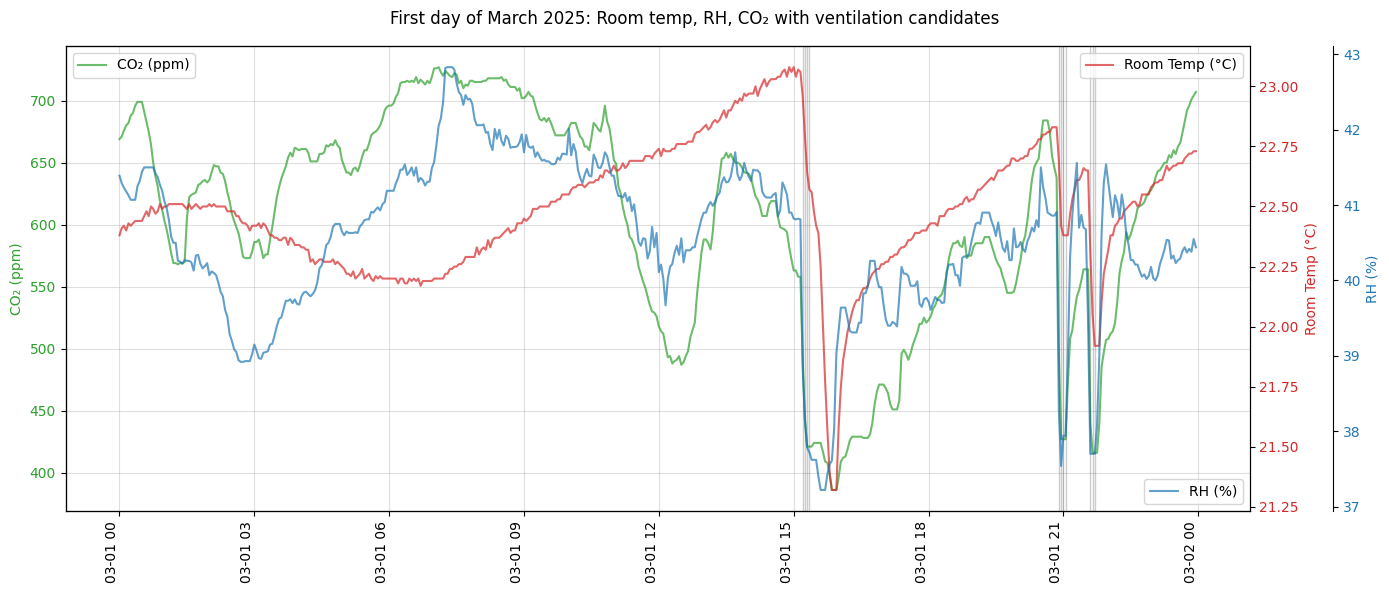

In [229]:
import matplotlib.pyplot as plt

# Select first week of February
start = '2025-03-01'
end = '2025-03-02'
week = df.loc[(df.index >= start) & (df.index < end)]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot CO2
ax1.plot(week.index, week['rco2_4'], label='CO₂ (ppm)', color='tab:green', alpha=0.7)
ax1.set_ylabel('CO₂ (ppm)', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Plot room temperature
ax2 = ax1.twinx()
ax2.plot(week.index, week['rtemp_4'], label='Room Temp (°C)', color='tab:red', alpha=0.7)
ax2.set_ylabel('Room Temp (°C)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot RH
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(week.index, week['rhumid_4'], label='RH (%)', color='tab:blue', alpha=0.7)
ax3.set_ylabel('RH (%)', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')

# Plot vertical lines for ventilation candidates
vents = week[week['vent_candidate'] == 1].index
for v in vents:
    ax1.axvline(v, color='k', alpha=0.2, lw=1)


mech_vents = week[week['mech_vent_candidate'] == 1].index
for v in mech_vents:
    ax1.axvline(v, color='red', alpha=0.2, lw=1)


ax1.grid(True, which='both', axis='both', alpha=0.4)
#ax1.xaxis.set_major_locator(mdates.HourLocator())
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

#ax1.xaxis.grid(True, which='major', linestyle=':', alpha=0.5)


fig.autofmt_xdate(rotation=90)
fig.suptitle('First day of March 2025: Room temp, RH, CO₂ with ventilation candidates')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64477 entries, 2024-11-17 06:00:00 to 2025-03-31 23:57:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   t_amb                64477 non-null  float64
 1   deltae               64477 non-null  float64
 2   rtemp_4              64477 non-null  float64
 3   rhumid_4             64477 non-null  float64
 4   rco2_4               64477 non-null  float64
 5   rco2_4_raw           64477 non-null  float64
 6   rtemp_4_raw          64477 non-null  float64
 7   rhumid_4_raw         64477 non-null  float64
 8   w_in                 64477 non-null  float64
 9   dco2_dt_9min         64474 non-null  float64
 10  dco2_dt_15min        64470 non-null  float64
 11  dT_dt_9min           64474 non-null  float64
 12  dT_dt_15min          64470 non-null  float64
 13  dw_dt_9min           64474 non-null  float64
 14  dw_dt_15min          64470 non-null  float64
 15  z

## Unsupervised occupancy classifier

The script implements a state-aware, two-stage procedure for inferring apartment occupancy from 3-minute indoor measurements. The first stage relies on features engineered beforehand to identify periods likely affected by natural or mechanical ventilation, as explained above.

Occupancy is then inferred only during "closed-envelope" periods, where the CO₂ signal primarily reflects the balance of metabolic generation and background air exchange. Three complementary cues are extracted. First, a rolling baseline for CO₂ is estimated as the 10th percentile over a 24-hour window (≈480 samples at 3 minutes). Subtracting this baseline from the current CO₂ level produces a non-negative CO₂ excess feature that captures persistent elevation over recent lows.

$$ CO_2^{excess}t = \max\left(0, CO_{2(t)} - \mathrm{quantile}{0.10}(CO_{2(t-24h, t)})\right) $$

Second, the CO₂ rise rate is taken from the smoothed 15-minute slope and filtered to retain only positive values, reflecting the short-term accumulation expected when occupants are present. Third, the moisture rise rate uses the humidity-ratio slope (again, filtered to consider only positive part), granting it lower weight than the CO₂ terms because of buffering by furnishings and episodic non-occupancy sources (e.g., cooking, showers).

Each cue is mapped to [0,1] by using a logistic function transform to normalize scale and flatten extreme values. For any z-score z:

$$ \mathrm{cue} = \frac{1}{1 + \exp\left(-\frac{z}{1.5}\right)} $$

The method then calculates a combination of cue probabilities with weights (0.6,0.3,0.1) for CO₂ excess, CO₂ slope, and moisture slope, respectively. This weighting emphasizes the most stable, physically grounded indicator (sustained CO₂ elevation) while still rewarding acute accumulations and moisture dynamics. The result is a continuous occupancy score ∈[0,1].

$$ occ_{score} = 0.6 \cdot cue_{excess} + 0.3 \cdot cue_{\Delta CO_2} + 0.1 \cdot cue_{\Delta w} $$

To convert the continuous score into a discrete state, the script applies a hysteretic decision rule with persistence. An ON transition (occupied) requires the score to exceed 0.65 for at least 6 minutes (2 samples), while an OFF transition (vacant) requires the score to fall below 0.48 for the same duration or the envelope to open. The above parameters have been adopted after several experiments. This asymmetric pair of thresholds, coupled with minimum-duration constraints, suppresses noise around the decision boundary and filters short-lived perturbations (e.g., momentary door openings, single breaths near the sensor and similar). The state machine is implemented explicitly, carrying forward the previous state and enforcing that ON cannot begin while the envelope is open.

Occupancy is considered valid only when the envelope is closed and the probability is finite. This produces a final binary series (occupancy) alongside a continuous series (occ_prob) that is informative for calibration and downstream fusion (e.g., with calendar priors). Parameter values, namely baseline quantile (10%), logistic scaling, weights, thresholds (0.65/0.48), and persistence (6 minutes) are meant to be room- and season-tunable. For example, apartments with higher infiltration may benefit from a slightly lower CO₂-excess weight and longer slope horizons. Compact, tight rooms can tolerate more sensitivity to the CO₂ slope. Finally, shower patterns may suggest down-weighting the moisture cue or conditioning it on time-of-day. All those parameters can be calibrated by using a small number of targetted experiments in the selected rooms and an analysis of the acquired data.

In [230]:
import numpy as np
import pandas as pd

# Start from engineered features


df["closed_env"] = ((df["vent_candidate"] == 0) & (df["mech_vent_candidate"] == 0)).astype(int)

# ------------------------------------------------------------
# CO2 baseline: rolling low quantile over 24h (robust to drift)
# 24h at 3-min sampling => 480 samples
# ------------------------------------------------------------
win_24h = 480
df["co2_base_24h_q10"] = df["rco2_4"].rolling(win_24h, min_periods=60).quantile(0.10)
df["co2_excess_ppm"] = (df["rco2_4"] - df["co2_base_24h_q10"]).clip(lower=0)

# Robust z-score of CO2 excess (global median/MAD)
x = df["co2_excess_ppm"]
med = x.median()
mad = (x - med).abs().median()
df["z_co2_excess"] = np.where((mad > 0) & np.isfinite(mad), 0.6745 * (x - med) / mad, np.nan)



# ------------------------------------------------------------
# Positive dynamics cues: CO2 slope and moisture slope (15 min)
# We use the robust z-scores built earlier; take only positive part for occupancy.
# ------------------------------------------------------------
df["z_dco2_dt"] = df["z_dco2_dt"].clip(lower=0)  # rising CO2 supports occupancy
df["z_dw_dt"]   = df["z_dw_dt"].clip(lower=0)    # rising humidity ratio supports occupancy


# ------------------------------------------------------------
# 4) Map each cue to [0,1] via a logistic, then combine into an occupancy score
#    Weights emphasize CO2 excess and slope; moisture is supportive, lower weight.
# ------------------------------------------------------------
# Numerical stability guards
for col in ["z_co2_excess", "z_dco2_dt", "z_dw_dt"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(0.0)

df["occ_cue_excess"] = 1.0 / (1.0 + np.exp(-(df["z_co2_excess"] / 1.5)))
df["occ_cue_dco2"]   = 1.0 / (1.0 + np.exp(-(df["z_dco2_dt"]   / 1.5)))
df["occ_cue_dw"]     = 1.0 / (1.0 + np.exp(-(df["z_dw_dt"]     / 1.5)))

# Weighted blend (sums to 1)
w_excess, w_dco2, w_dw = 0.5, 0.4, 0.1
#w_excess, w_dw = 0.7, 0.3
df["occ_score_raw"] = (
    w_excess * df["occ_cue_excess"] +
    w_dco2  * df["occ_cue_dco2"] +
    w_dw    * df["occ_cue_dw"]
)

# Apply envelope gating: do not assert occupancy when envelope is open
df["occ_prob"] = np.where(df["closed_env"] == 1, df["occ_score_raw"], np.nan)


# ------------------------------------------------------------
# 5) Hysteresis + minimum on/off durations to avoid chatter
#    - Turn ON if occ_prob >= th_on for ≥ min_on samples (3-min samples).
#    - Turn OFF if occ_prob <= th_off for ≥ min_off samples or envelope opens.
# ------------------------------------------------------------
th_on  = 0.65   # ON threshold on [0,1]
th_off = 0.48   # OFF threshold on [0,1]
min_on_samples  = 2   # ≥ 12 minutes
min_off_samples = 2   # ≥ 12 minutes

# Precompute "on" and "off" candidate runs
on_sig  = (df["occ_prob"] >= th_on) & (df["closed_env"] == 1)
off_sig = ((df["occ_prob"] <= th_off) | (df["closed_env"] == 0))

# Rolling sums to demand persistence
on_hits  = on_sig.rolling(min_on_samples, min_periods=min_on_samples).sum()  >= min_on_samples
off_hits = off_sig.rolling(min_off_samples, min_periods=min_off_samples).sum() >= min_off_samples

# Stateful pass to apply hysteresis cleanly
state = np.zeros(len(df), dtype=int)
on_hits_vals  = on_hits.to_numpy()
off_hits_vals = off_hits.to_numpy()
closed_vals   = (df["closed_env"] == 1).to_numpy()


for i in range(len(df)):
    if i == 0:
        state[i] = 0
        continue

    s_prev = state[i-1]

    # If envelope is open, keep previous state but do not switch ON
    if not closed_vals[i]:
        # allow OFF if prolonged open envelope is flagged as off_hit
        if off_hits_vals[i]:
            state[i] = 0
        else:
            state[i] = s_prev
        continue

    # Closed-envelope:
    if s_prev == 0:
        # Switch ON only when sustained ON condition is met
        state[i] = 1 if on_hits_vals[i] else 0
    else:
        # Switch OFF only when sustained OFF (or envelope opened earlier in rolling window)
        state[i] = 0 if off_hits_vals[i] else 1

df["occ_state_raw"] = state



# ------------------------------------------------------------
# 6) Confidence mask and final binary occupancy
#    - Confident only when envelope is closed.
# ------------------------------------------------------------
df["occ_confident"] = ((df["closed_env"] == 1) & np.isfinite(df["occ_prob"])).astype(int)
df["occupancy"] = np.where(df["occ_confident"] == 1, df["occ_state_raw"], 0).astype(int)


conf_mask = df["occ_confident"] == 1
occ_rate = df.loc[conf_mask, "occupancy"].mean()
print(f"Mean occupancy (confident windows only): {occ_rate:.2%}")


Mean occupancy (confident windows only): 54.84%


The figure below presents a plot for the first half of February 2025, with occupancy probability (occ_prob, left y-axis, [0,1]) and z-scores of cues derived from indoor air measurements (z_co2_excess, z_dco2_dt, z_dw_dt. Grey background bands denote ventilation candidates inferred from the triad of rapid declines in CO₂, humidity ratio, and temperature. Yellow shaded intervals mark the resulting inferred occupied periods, and thin grey vertical bands denote detected window-opening events. The temporal pattern is characteristically residential: most days exhibit extended daytime or evening occupied segments (yellow bands with occ_prob frequently ≳0.6–0.8) separated by minima, with moderate day-to-day variability in onset and duration.

Window-opening events (grey bands) are inferred within all but one of the yellow occupied intervals and coincide with sharp declines in the cue z-scores, indicating rapid dilution and moisture changes during brief airing, while occupants remain present. This is an important indicator of robustness of the approach, as occupancy score remains high even with rapid declines of CO2, produced by the ventilation episodes. Overall, the concurrence of (i) elevated occ_prob within yellow spans, (ii) spike-like cue anomalies at grey bands, and (iii) low occ_prob overnight demonstrates that the detector distinguishes routine occupancy from short airing episodes, detecting behaviorally plausible daily patterns.

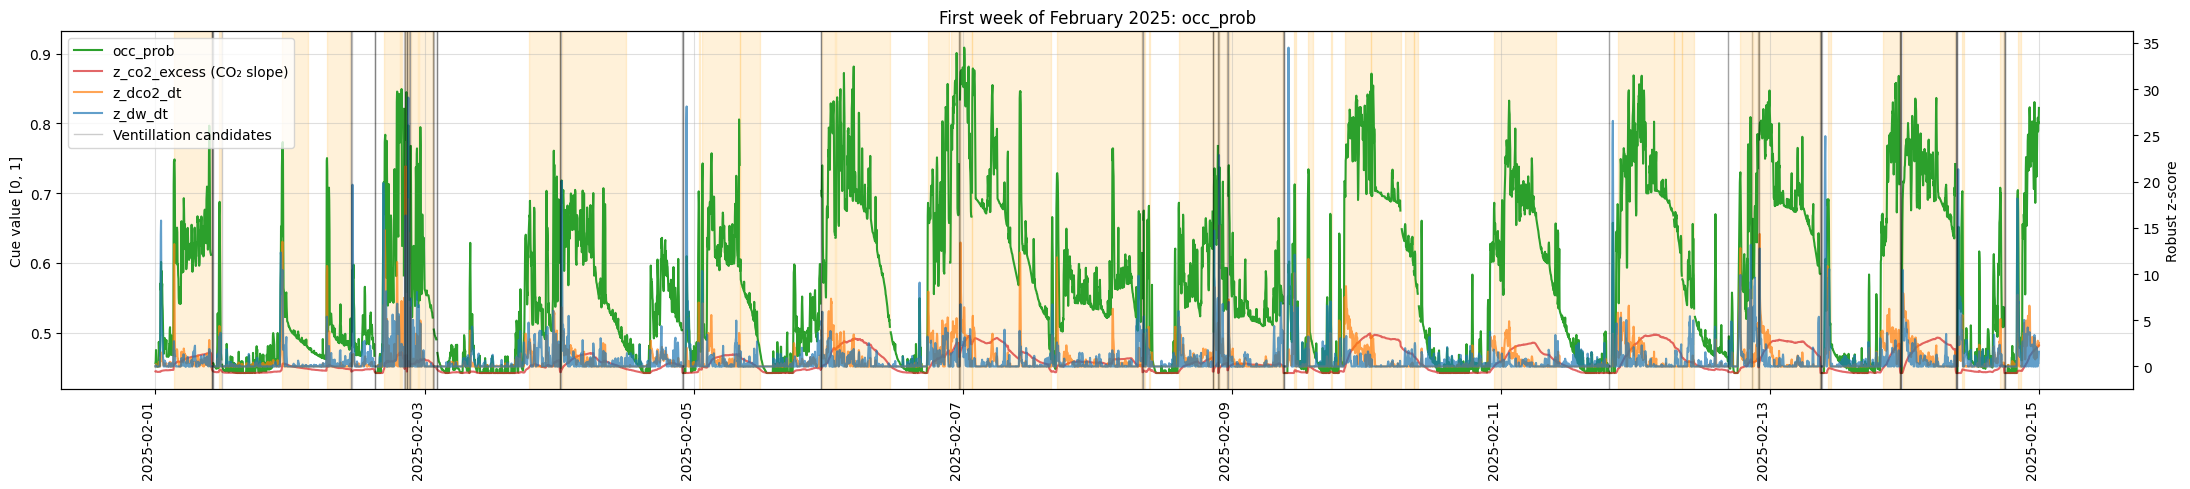

In [231]:
# Select first week of February
start = '2025-02-01'
end = '2025-02-15'

#start = '2025-03-01'
#end = '2025-03-03'

week = df.loc[(df.index >= start) & (df.index < end)]

# Get occupancy intervals (where occupancy==1)
occ = week.get("occupancy", None)

# Find start and end times of occupancy episodes
occ_diff = occ.astype(int).diff().fillna(0)
on_times = week.index[(occ_diff == 1) | ((occ.iloc[0] == 1) & (occ_diff.index == week.index[0]))]
off_times = week.index[(occ_diff == -1) | ((occ.iloc[0] == 1) & (occ_diff.index == week.index[-1]))]

fig, ax = plt.subplots(figsize=(22, 5))


ax.plot(week.index, week['occ_prob'], label='occ_prob', color='tab:green')
ax2 = ax.twinx()
ax2.plot(week.index, week['z_co2_excess'], label='z_co2_excess (CO₂ slope)', color='tab:red', alpha=0.7)
ax2.plot(week.index, week['z_dco2_dt'], label='z_dco2_dt', color='tab:orange', alpha=0.7)
ax2.plot(week.index, week['z_dw_dt'], label='z_dw_dt', color='tab:blue', alpha=0.7)
ax2.set_ylabel('Robust z-score')
lines1, labels1 = ax.get_legend_handles_labels()



# Plot vertical lines for ventilation candidates
vents = week[week['vent_candidate'] == 1].index
for v in vents:
    ax2.axvline(v, color='k', alpha=0.2, lw=1, label='Ventillation candidates' if v == vents[0] else None)


lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax.set_ylabel('Cue value [0, 1]')
ax.set_title('First week of February 2025: occ_prob')

ax.grid(True, which='both', axis='both', alpha=0.4)


# Highlight occupancy intervals with rectangles
for start_time, end_time in zip(on_times, off_times):
    ax.axvspan(start_time, end_time, color='orange', alpha=0.15, label='Occupied')


fig.autofmt_xdate(rotation=90)
plt.tight_layout()
plt.show()

The figure nelow plots hourly occupancy rates aggregated across days and stratified by weekdays (Mon–Fri) and weekends (Sat–Sun). Only confident, closed-envelope windows are included. A clear diurnal structure is evident. On weekdays, occupancy is highest during the night and early morning (≈ 67–86% from 00:00–03:00), declines steadily through the late morning, and reaches a pronounced mid-afternoon minimum (≈ 17–19% around 15:00–16:00), consistent with residents being away for work. Rates then recover in the evening, rising into the 40–50% range by 20:00–23:00. Weekends exhibit a similar shape but are systematically higher during daytime and evening. Mid-day/afternoon values remain elevated relative to weekdays (≈ 33–40% vs. ≈ 17–28%), and evening peaks are notably stronger (≈ 65–67% at 21:00–23:00). Finally, during the deep night (≈ 00:00–03:00) weekdays slightly exceed weekends, which is consistent with more uniform sleep-at-home patterns on work nights.

The weekday–weekend contrast therefore aligns with expected residential behavior: lower daytime presence on workdays, sustained daytime and evening presence on weekends. The confidence intervals are generally modest, indicating stable estimates for most hours. Overall, the plot suggests that the detector captures behaviorally plausible occupancy rhythms—nocturnal plateaus, weekday mid-day troughs, and weekend persistence.

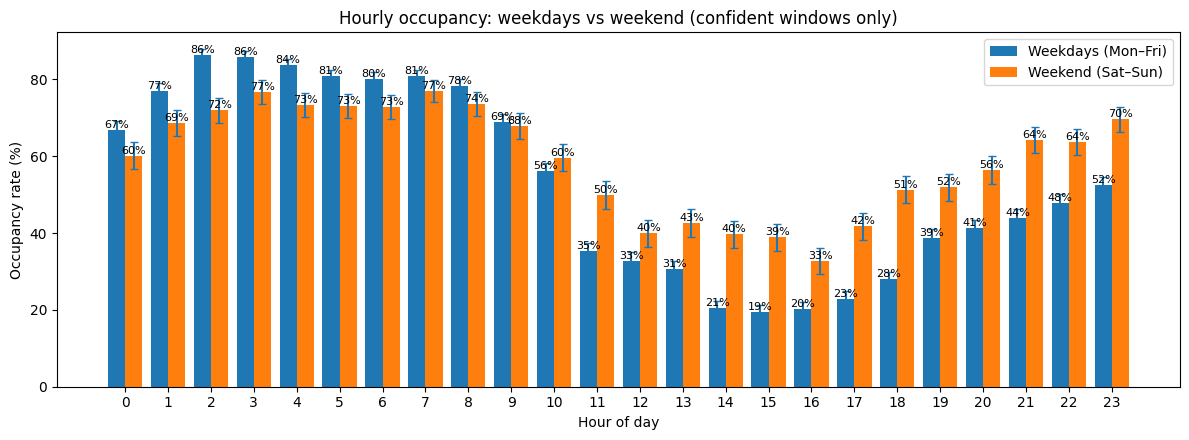

In [232]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Assumptions:
# - df is your DataFrame with:
#     'occupancy' (0/1), optional 'occ_confident' (1 when valid)
# - Index is a DateTimeIndex at 3-min cadence
# ------------------------------------------------------------------

# Ensure DateTimeIndex and sort
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce")
df = df.sort_index()

# Use only confident, closed-envelope samples if available
if "occ_confident" in df.columns:
    mask = (df["occ_confident"] == 1) & df["occupancy"].notna()
else:
    mask = df["occupancy"].notna()
mask = mask.reindex(df.index, fill_value=False)

# Apply mask
dfm = df.loc[mask].copy()
if dfm.empty:
    raise RuntimeError("No samples after masking; check 'occ_confident' or occupancy availability.")

# Hour-of-day and weekend flag
dfm["hour"] = dfm.index.hour
dfm["is_weekend"] = dfm.index.dayofweek >= 5  # Sat=5, Sun=6

# Aggregation: mean occupancy per hour (as %) and sample counts
wk_mask = ~dfm["is_weekend"]
we_mask =  dfm["is_weekend"]

occ_wk = dfm.loc[wk_mask].groupby("hour")["occupancy"].mean().reindex(range(24), fill_value=0.0) * 100.0
occ_we = dfm.loc[we_mask].groupby("hour")["occupancy"].mean().reindex(range(24), fill_value=0.0) * 100.0

n_wk = dfm.loc[wk_mask].groupby("hour")["occupancy"].size().reindex(range(24), fill_value=0)
n_we = dfm.loc[we_mask].groupby("hour")["occupancy"].size().reindex(range(24), fill_value=0)

# Optional: 95% binomial CIs (set to 0 where n=0)
p_wk = (occ_wk.values / 100.0)
p_we = (occ_we.values / 100.0)
n_wk_safe = np.clip(n_wk.values, 1, None)
n_we_safe = np.clip(n_we.values, 1, None)
se_wk = np.sqrt(p_wk * (1 - p_wk) / n_wk_safe) * 100.0
se_we = np.sqrt(p_we * (1 - p_we) / n_we_safe) * 100.0
ci95_wk = 1.96 * se_wk
ci95_we = 1.96 * se_we
ci95_wk[n_wk.values == 0] = 0.0
ci95_we[n_we.values == 0] = 0.0

# ---- Plot: grouped bars ----
x = np.arange(24)
width = 0.4

fig, ax = plt.subplots(figsize=(12, 4.5))
bars_wk = ax.bar(x - width/2, occ_wk.values, width, label="Weekdays (Mon–Fri)")
bars_we = ax.bar(x + width/2, occ_we.values, width, label="Weekend (Sat–Sun)")

# Error bars
ax.errorbar(x - width/2, occ_wk.values, yerr=ci95_wk, fmt='none', capsize=3)
ax.errorbar(x + width/2, occ_we.values, yerr=ci95_we, fmt='none', capsize=3)

ax.set_xticks(x)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Occupancy rate (%)")
title_suffix = " (confident windows only)" if "occ_confident" in df.columns else ""
ax.set_title(f"Hourly occupancy: weekdays vs weekend{title_suffix}")
ax.legend()

# Optional: annotate bars with percentages
for rect in list(bars_wk) + list(bars_we):
    h = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, h, f"{h:.0f}%", ha="center", va="bottom", fontsize=8, rotation=0)

plt.tight_layout()

ax.legend()
plt.show()

# Discussion and intended use

We consider producing a real-valued occupancy score (a probability or confidence in [0,1]), rather than only a binary occupied/unoccupied label, as very important aspect of the model for both methodological rigor and practical deployment. 

A continuous score preserves information about uncertainty inherent in the sensing process: the same CO₂/RH/temperature patterns can be generated by different latent causes (quiet presence, brief absence, ventilation micro-events). Collapsing these into a hard label discards the strength of evidence and the ambiguity due to noise, missing data, or room-specific dynamics (volume, leakage, sensor placement). Next, a score expresses a calibratable quantity. With even limited ground truth (e.g., from door/window contacts or episodic spot checks), one can assess calibration via reliability diagrams and optimize it with isotonic regression or Platt scaling. From a decision-theoretic standpoint, continuous confidence enables threshold selection matched to use-case costs. Heating/ventilation control, demand response, and analytics value precision and recall differently: an energy-saving controller may prefer a higher threshold (fewer false ONs), whereas safety or security monitoring may prefer a lower one (fewer false OFFs). With a score, these trade-offs are tuned ex ante by choosing 𝜏<sub>on</sub>, 𝜏<sub>off</sub> hysteresis. With only a binary label, such tailoring is impossible. Moreover, performance can be summarized across thresholds via ROC/AUC curves and expected cost under application-specific loss functions.

Finally, its important to highlight again that the proposed approach works on a full time series and not on an online data stream, meaning that, as is, it cannot be applied in a control loop. However, occupancy probability provides an opportunity to build a weak or semi-supervised classifier based on binary occupancy data derived from high confidence scores, which can indeed work on a data stream, by also considering many other relevant features, additional to the ones used by this method. This approach is part of the plans of our future work and it is described in the next section.

In practice, the online occupancy data stream can drive a simple supervisory control layer that switches the heating sub-system between operational modes such as Away, Home, Sleep, Ventilating, or Unknown. Transitions can be governed by the level and stability of the probability together with the inferred envelope state (window open vs. closed). In the end-users with room thermostats or valves, the occupance score could modulate setbacks and comfort setpoints. Increasing probability can trigger pre-heating so that comfort is reached by the time occupants settle. Even in the end-users without having room thermal comfort control available, the same signal can bias control targets, such as secondary supply temperature, so that the sub-station pumps run slightly more conservative during broadly unoccupied periods and in the normal mode, when the building is largely occupied. Finally, a continuous score enhances interpretability. Since the score is constructed by using physically meaningful features (CO₂ excess and slopes, humidity dynamics) and modulated by a transparent gate (ventilation state), operators can trace contributions of each cue and justify control decisions. This inherent explainability of the model is important for stakeholder trust in residential settings, where false positives/negatives have comfort and energy implications.

# Conclusions

This paper presented a ventilation-aware, physics-informed approach to weakly labeling occupancy in district-heated apartments using three signals: indoor CO₂, relative humidity (converted to humidity ratio), and room temperature. The method operationalizes two coupled tasks. First, the detection of open-envelope periods (natural or mechanical ventilation) with using the interplay of the CO₂-moisture-temperature triad, and, second, the inference of occupancy. The design remains agnostic to the presence of room thermostats and explicitly excludes delivered energy data as a primary detector when no local feedback control exists.

Empirical analyses support the internal consistency and behavioral plausibility of the detector. At the daily scale, occupancy probabilities form extended diurnal plateaus separated by nocturnal minima. Aggregated to the hour-of-day, the estimates exhibit the expected contrast between weekdays (mid-day troughs consistent with residents being away) and weekends (persistently higher daytime and evening presence). These qualitative and aggregate evidences are aligned with residential routines and indicate that the method captures both within-day dynamics and day-type effects. Equally important, the confidence output preserves uncertainty information essential for downstream decision-making, performance calibration, and risk-aware actuation.

Methodologically, the work contributes two key elements: (i) a feature engineering approach with associated pre-processing that considers both physical fidelity and robustness (Hampel filtering, MAD-based scaling); and (ii) an interpretable scoring mechanism with normalization (by using logistic function) that produces a probability score. While the evaluation is necessarily indirect in the absence of ground truth at scale, the convergence of multiple lines of evidence, such as event-level alignment, stable diurnal structure, and weekday-weekend differentials, overall provides validity that the approach is effectively detecting the intended occupancy.

As a clear aim for future work, we will generalize the present state-aware, rule-guided detector into a weak-/semi-supervised learning framework that uses its occupancy confidence to generate pseudo-labels of varying reliability while introducing a richer set of predictors. Specifically, sustained high probabilities under closed-envelope conditions will define high-confidence positives, and extended low probabilities will define high-confidence negatives. Mid-range or ventilation-adjacent segments will be treated as ambiguous and hence, discarded in the training a new weakly-supervised model. In addition, we will record a small number of window ventillation and occupancy episodes, and use this acquired data for calibrating the weak labeling method we presented in this paper.

These weak labels will supervise a discriminative classifier trained on an expanded feature space that includes the existing CO₂, temperature, and psychrometric variables and their multi-timescale derivatives, change-point indicators, time-of-day/week encodings, recent temporal history and persistence features, the inferred ventilation/mechanical-ventilation state, and contextual signals such as delivered energy (interpreted passively in our no-thermostat setting) and room metadata. This weak-supervision pathway will preserve the physics-based interpretability of the current method, and it is expected to produce a calibrated, auditable classifier suitable for real-time supervisory control and demand-responsive operation.

# Literature

Ahmad, J., Larijani, H., Emmanuel, R., Mannion, M., & Javed, A. (2021). Occupancy detection in non-residential buildings – A survey and novel privacy preserved occupancy monitoring solution. Applied Computing and Informatics, 17(2), 279–295. https://doi.org/10.1016/j.aci.2018.12.001

Atashgahi, Z., Mocanu, D. C., Veldhuis, R., & Pechenizkiy, M. (2022). Memory-free Online Change-point Detection: A Novel Neural Network Approach (Version 2). arXiv. https://doi.org/10.48550/ARXIV.2207.03932

Chen, Z., Jiang, C., & Xie, L. (2018). Building occupancy estimation and detection: A review. Energy and Buildings, 169, 260–270. https://doi.org/10.1016/j.enbuild.2018.03.084

Esmaieeli-Sikaroudi, A.-M., Goikhman, B., Chubarov, D., Nguyen, H. D., Chertkov, M., & Vorobev, P. (2024). Physics-Informed Building Occupancy Detection: A Switching Process with Markov Regime (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2409.11743

Hampel, F. R. (1974). The Influence Curve and its Role in Robust Estimation. Journal of the American Statistical Association, 69(346), 383–393. https://doi.org/10.1080/01621459.1974.10482962

Jiang, C., Chen, Z., Su, R., Masood, M. K., & Soh, Y. C. (2020). Bayesian filtering for building occupancy estimation from carbon dioxide concentration. Energy and Buildings, 206, 109566. https://doi.org/10.1016/j.enbuild.2019.109566

Jiang, J., Irga, P., Coe, R., & Gibbons, P. (2024). Effects of indoor plants on CO2 concentration, indoor air temperature and relative humidity in office buildings. PLOS ONE, 19(7), e0305956. https://doi.org/10.1371/journal.pone.0305956

Kampezidou, S. I., Ray, A. T., Duncan, S., Balchanos, M. G., & Mavris, D. N. (2021). Real-time occupancy detection with physics-informed pattern-recognition machines based on limited CO2 and temperature sensors. Energy and Buildings, 242, 110863. https://doi.org/10.1016/j.enbuild.2021.110863

Karasoulas, C., Keroglou, C., Katsiri, E., & Sirakoulis, G. Ch. (2023). Hidden Markov models for presence detection based on CO2 fluctuations. Frontiers in Robotics and AI, 10, 1280745. https://doi.org/10.3389/frobt.2023.1280745

Li, Y., Chen, Q., Cheng, Q., Li, K., Cao, B., & Huang, Y. (2022). Evaluating the Influence of Different Layouts of Residential Buildings on the Urban Thermal Environment. Sustainability, 14(16), 10227. https://doi.org/10.3390/su141610227

Mohammadabadi, A., Rahnama, S., & Afshari, A. (2022). Indoor Occupancy Detection Based on Environmental Data Using CNN-XGboost Model: Experimental Validation in a Residential Building. Sustainability, 14(21), 14644. https://doi.org/10.3390/su142114644

Pereira, P. F., & Ramos, N. M. M. (2018). Detection of occupant actions in buildings through change point analysis of in-situ measurements. Energy and Buildings, 173, 365–377. https://doi.org/10.1016/j.enbuild.2018.05.050

Zdravković, M., Cvetković, S., Ignjatović, M., Ćirić, I., Mitrović, D., Stojiljković, M., Nejković, V., Stojiljković, D., & Turudija, R. (2024). XAI4HEAT: Towards Demand-Driven, AI Facilitated Management of District Heating Systems. In M. Trajanović, N. Filipović, & M. Zdravković (Eds.), Disruptive Information Technologies for a Smart Society (Vol. 860, pp. 23–34). Springer Nature Switzerland. https://doi.org/10.1007/978-3-031-71419-1_3
